보조지표 MACD를 활용한 코스피 200 종목 분석https://kpumangyou.tistory.com/92

# MACD
- MACD 곡선 = 단기지수이동평균-장기지수이동평균
- Signal 곡선 = n일의 MACD 지수이동평균
    - 보통 단기지수이동평균는 12일 장기지수이동평균은 26일을 사용한다. 그리고 Signal곡선의 n은 9일을 일반적으로 사용한다.
- MACD 곡선이 Signal 곡선을 상향 돌파시 : 매수  
- MACD 곡선이 Signal 곡선을 하향 돌파시 : 매도

- 백테스팅이란?
    - 과거 데이터를 활용해 자신의 알고리즘, 투자전략 원칙을 검증하는 과정을 의미한다.

    - 초기투자금액 설정, 시작일이나 종료일을 설정하거나 매매나 수익의 분석을 제공하는 등의 성과를 분석하여 어느 정도의 수익을 낼 수 있는지를 확인하는 것.
    - 즉, 과거의 데이터(Back)와 알고리즘을 테스트한다는 의미인 테스팅(testing)이 결합된 용어

## 퀀트
* 가치투자-> 계량투자
* 장기투자-> 단기투자
* 직관투자-> 과학투자(수학,통계)
* 투자산업발달
    * 예측
    * 투자 세력
        - 매수 세력
        - 매도 세력
    * 금융 상품
        - 셀사이드: 금융상품을 만들어 파는쪽
        - 바이사이드: 금융상품을 사는쪽
        - 중개소 발달
* 투자퀀트
    - 기본:이동평균선
    - MACD(Moving Average Convergence Divergence) 
        - 이동평균 수렴 확산 지수
        - 이동평균선의 거리의 변화에 따른 신호를 포착하여 매수 매도 타이밍을 포착
        - 가정
            - 장이평선이 기준선으로 장기적 상승과 하락을 표현
            - 장이평선에서 단이평선이 멀어지면 
            - 단이평선은 장이평선으로 가까이갈 힘을 받는다
        - 매매타이밍
            - 단이평선이 장이평선 위에서 점점 상승세가 줄고 있다(매도)
                - 데드크로스
                - MACD선이 시그널선을 뚫고 내려올때
            - 단이평선이 장이평선 아래서 점점 하락세가 줄고 있다(매수)
                - 골든크로스
                - MACD 선이 시그널선을 뚫고 올라갈때
        - 계산
            - MACD 단이평선-장이평선 
            - 시그널 : MACD 이평선
            - 기본값(단기 12,단기선 26,장기선 9시그널)
        - 한계
            - 횡보장에서 MACD 크로스가 많이 발생하면서 거짓신호가 많음
            - 교차시 각도를 주의
            
            
            

In [2]:
import sqlite3
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

In [15]:
def seldata(cols=['sday','sclose'],where='where sday>"2022-01-01" order by sday asc'):
    fname='_db/nstock.db'
    with sqlite3.connect(fname) as conn:
        cur=conn.cursor()
        coltxt=','.join(cols)
        sql='select '+coltxt+' from stockdb '+where
        print(sql)
        res=cur.execute(sql).fetchall()
    return res

res=seldata()    
res[:5]

select sday,sclose from stockdb where sday>"2022-01-01" order by sday asc


[('2022-01-03', 128500),
 ('2022-01-04', 128500),
 ('2022-01-05', 125500),
 ('2022-01-06', 125000),
 ('2022-01-07', 127000)]

In [30]:
cols=['sday','sclose']
df = pd.DataFrame(res,columns=cols)
mdf=df.set_index('sday')
mdf.tail()

,sclose
sday,
2022-05-06,107500
2022-05-09,107500
2022-05-10,110000
2022-05-11,110500
2022-05-12,110500


In [31]:
## 단이평선 12
mdf['shortl']=mdf['sclose'].rolling(window=12).mean()

## 장이평선 26
mdf['longl']=mdf['sclose'].rolling(window=26).mean()

In [32]:
## 시그널 9
mdf['macd']=mdf['shortl']-mdf['longl']
mdf['sig']=mdf['macd'].ewm(span=9).mean()

In [33]:
mdf.tail()

,sclose,shortl,longl,macd,sig
sday,,,,,
2022-05-06,107500,110250.000000,111692.307692,-1442.307692,-2446.527931
2022-05-09,107500,109833.333333,111288.461538,-1455.128205,-2248.247682
2022-05-10,110000,109583.333333,111057.692308,-1474.358974,-2093.469751
2022-05-11,110500,109583.333333,110807.692308,-1224.358974,-1919.647425
2022-05-12,110500,109791.666667,110576.923077,-785.256410,-1692.769044


In [36]:
def simStock(mdf,stxt='shortmv',ltxt='longmv'):
    findex=mdf.iloc[:1,:].index[0]
    lindex=mdf.iloc[-1:,:].index[0]
    lindex
    invest=200000
    beforePos=-1
    beforeHold=0

    for i,row in mdf.iloc[10:,:].iterrows():
        if(row[stxt]>=row[ltxt]):
            nowpos=1 # short 상위
        else:
            nowpos=-1 # short 하위
        if beforePos==-1 and nowpos==1 and beforeHold==0:
            timing=1 # 매수타이밍
            hold=1
            mdf.loc[i,'cash']=-row['sclose']
            mdf.loc[i,'hold']=1
        elif beforePos==1 and nowpos==-1 and beforeHold==1:
            timing=-1 # 매수타이밍
            hold=0
            mdf.loc[i,'cash']=row['sclose']
            mdf.loc[i,'hold']=0
        else:
            mdf.loc[i,'cash']=0
            timing=0 # 홀드
            hold=beforeHold
            mdf.loc[i,'hold']=beforeHold
        beforeHold=hold
        beforePos=nowpos
        mdf.loc[findex,'cash']=invest
        mdf['cumcash']=mdf['cash'].cumsum()
        mdf['balalce']=mdf['sclose']*mdf['hold']+mdf['cumcash']
    mdf.tail()
    ecash=mdf.loc[lindex,'balalce']-invest
    erate=ecash/invest
    return(invest,ecash,erate)

In [37]:
simStock(mdf,'macd','sig')

(200000, -7000.0, -0.035)

In [38]:
# 일반 이평선 기반 투자
## 단이평선 12
mdf['shortNmv']=mdf['sclose'].ewm(span=12).mean()
## 장이평선 26
mdf['longNmv']=mdf['sclose'].ewm(span=26).mean()
simStock(mdf,'shortNmv','longNmv')

(200000, -16000.0, -0.08)

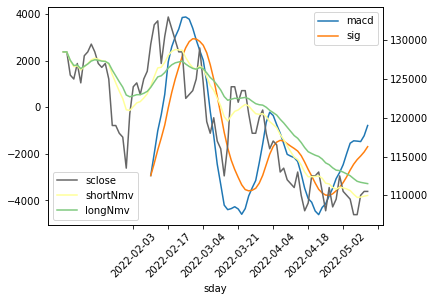

In [70]:
fig,ax1=plt.subplots()
mdf[['macd','sig']].plot(ax=ax1, rot=45)
ax2=ax1.twinx()

#ax1.get_xaxis().set_visible(False)

mdf[['sclose','shortNmv','longNmv']].plot(ax=ax2,cmap='Accent_r').legend(loc='lower left')

plt.show()